### Classification Solutions

In [26]:
# Importing the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import ( ModelSpec as MS, summarize )
from ISLP import confusion_table
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [13]:
data = load_data("Weekly")
data.head(), data.shape

(   Year   Lag1   Lag2   Lag3   Lag4   Lag5    Volume  Today Direction
 0  1990  0.816  1.572 -3.936 -0.229 -3.484  0.154976 -0.270      Down
 1  1990 -0.270  0.816  1.572 -3.936 -0.229  0.148574 -2.576      Down
 2  1990 -2.576 -0.270  0.816  1.572 -3.936  0.159837  3.514        Up
 3  1990  3.514 -2.576 -0.270  0.816  1.572  0.161630  0.712        Up
 4  1990  0.712  3.514 -2.576 -0.270  0.816  0.153728  1.178        Up,
 (1089, 9))

`Weekly` is similar to `Smarket` but it has around 1089 entries from the beginning of 1990 to end of 2010.

In [25]:
data.loc[:, "Direction"].value_counts()

Direction
Up      605
Down    484
Name: count, dtype: int64

In [61]:
data_wo_direction = data.loc[:, "Year" : "Today"]
data_wo_direction.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


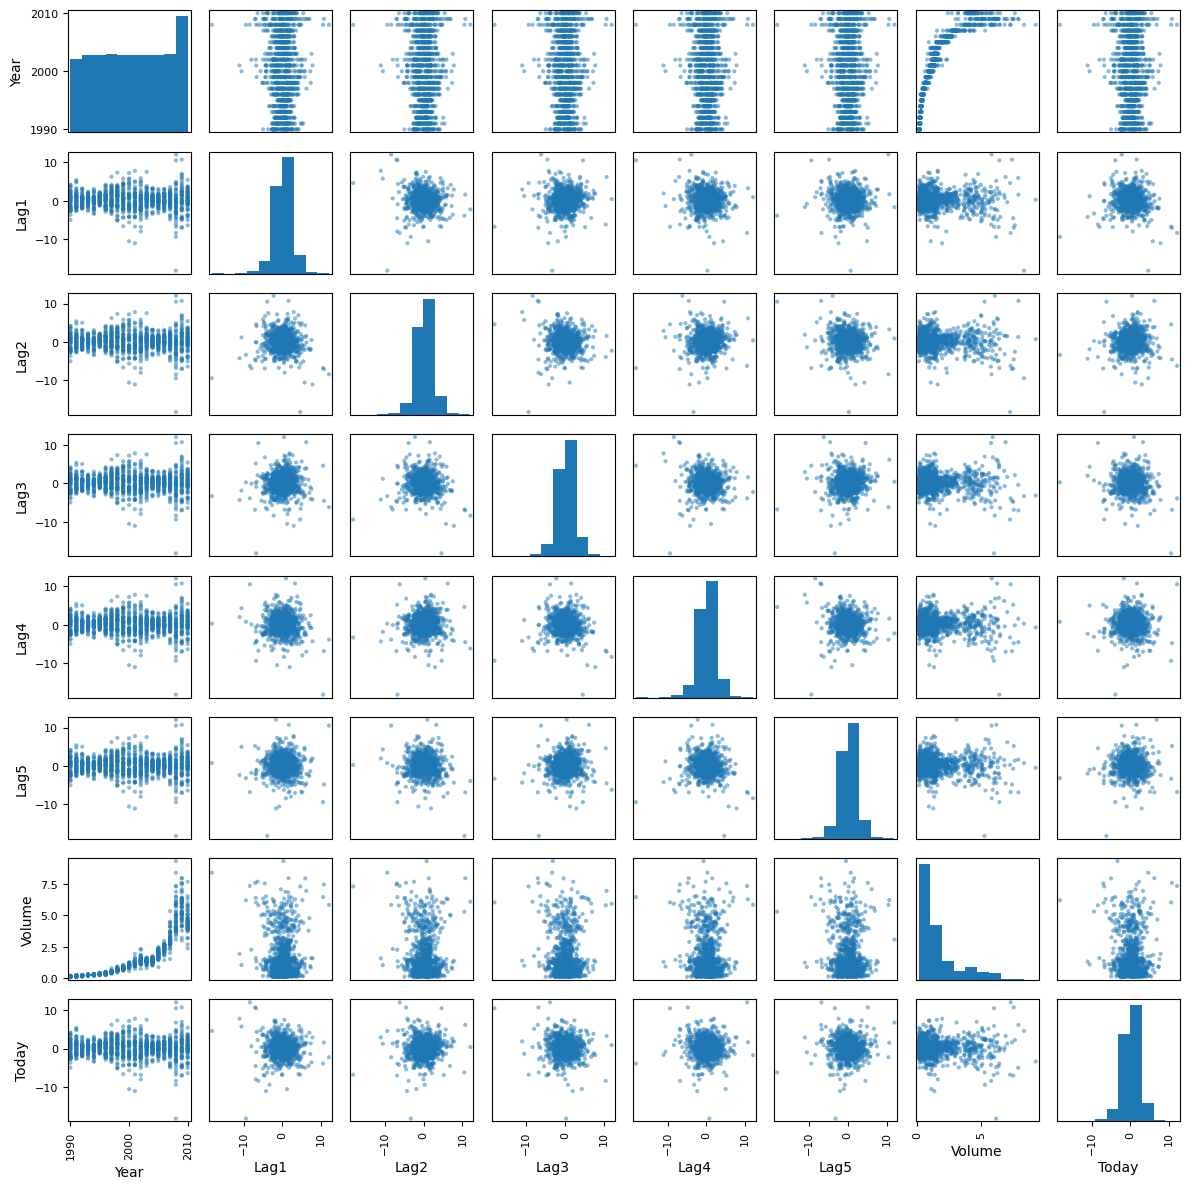

In [62]:
# Some graphical summaries - best corr matrix?
pd.plotting.scatter_matrix(data, figsize = (12,12))
plt.tight_layout()
plt.show()

I think the volume is increasing non linearly with year. Rest pretty much of no use i think

In [54]:
# Direction as a response & five lag variables + volume
vals = data.columns.drop(["Year", "Today", "Direction"])
x = MS(vals).fit_transform(data)
y = data.loc[:,"Direction"] == "Up"

logit_model = sm.GLM(y,x, family = sm.families.Binomial()).fit()
summarize(logit_model)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


Only `Lag1` seems to be significant, maybe because of the correlation one is carrying the weight of the other but there is none correlation. 

In [71]:
# Computing the confusion matrix
probs = logit_model.predict()
labels_pred = np.where(probs >= 0.5, "Up", "Down")
confusion_table(labels_pred, data.loc[:, "Direction"])

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


1. Accuracy : $\frac{54+557}{1089} \approx 0.561 \, (56.1\%)$
2. Precision : $\frac{557}{557+430} \approx 0.564 \, (56.4\%)$
3. Recall : $\frac{557}{557 + 48} \approx 0.921 \, (92.1\%)$
4. Specificity : $\frac{54}{54+430} \approx 0.111 \, (11.1\%)$

Inference : <br> 
- Model has very good recall, it can identify actual positives as positives around 92% of time.
- Very low specificity, it cannot predict true negatives well.
- Accuracy is somewhere around 56.1%, expect it to decrease with testing dataset
- Precision is somewhere around 56.4%, around 56.4% of times model is correctly predicting the true positives, high rate due to large number of false positives.

Though the model is good at identifying positives but due to large number of false positives it cannot predict true positives well